<a href="https://colab.research.google.com/github/acse-2019/acse4-4-gauss/blob/master/model_predict_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!sudo apt-get update
!sudo apt-get install wget
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AL0Rh5mjPgQH3pKrWqJlxVcbuAgXbON7" -O data.zip && rm -rf /tmp/cookies.txt
from zipfile import ZipFile
with ZipFile('./data.zip', 'r') as zipObj:
    print("Started unzipping... \n")
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
    print("Files unziped sucessfully\n")
!ls

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,818 kB]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Rel

In [0]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader, Dataset, SubsetRandomSampler
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

from livelossplot import PlotLosses

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:
## set global hyperparameters
seed = 42
lr = 1e-2
momentum = 0.9
batch_size = 250
test_batch_size = 1000
n_epochs = 100
weight_decay = 1e-5

In [0]:
mean = [0.48024845, 0.44807208, 0.39754644]
std  = [0.27698642, 0.26906449, 0.28208190]

## make transforms
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])
train_transform = transforms.Compose([transforms.ToPILImage(),  
                                      # transforms.ColorJitter(brightness=(1.,1.),  # do nothing to brightness
                                                            #  contrast=(0.5, 1.5), # change contrast
                                                            #  saturation=(1.,1.),  # do nothing to saturation
                                                            #  hue=(0.,0.)),        # do nothing to hue
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(64, padding=5),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                      ])

## Load the data into datasets (data not in memory)
training_data = ImageFolder('./train/', transform=transforms.ToTensor()) # do not wan to transform training data before it has been split
test_data = ImageFolder('./test/', transform=test_transform)
labels = list(training_data.class_to_idx.values())

## create a random split for the training set into validation set
val_size = 0.1
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=seed).split(np.zeros(len(training_data)), training_data.targets)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

## Training and validation samplers for data loaders
training_sampler   = SubsetRandomSampler(indices[0])
validation_sampler = SubsetRandomSampler(indices[1])

## Training and validation data loaders
train_loader_      = DataLoader(training_data, batch_size,      sampler=training_sampler,   shuffle=False, num_workers=4)
validation_loader_ = DataLoader(training_data, test_batch_size, sampler=validation_sampler, shuffle=False, num_workers=4)

In [0]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transformation=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transformation = transformation
    
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        if self.transformation:
            img = self.transformation(img)
            
        return img, label
    
    def __len__(self):
        return len(self.data)

In [0]:
## Pre-load the dataset into memory for faster access during training
num_data  = len(training_data)
num_train = int(num_data*(1-val_size))
num_val   = num_data - num_train

X_train, y_train = torch.Tensor(num_train, 3, 64, 64), torch.LongTensor(num_train)
X_val  , y_val   = torch.Tensor(num_val  , 3, 64, 64), torch.LongTensor(num_val)

idx = 0
for X_, y_ in train_loader_:
    bsize = X_.size(0)
    X_train[idx:idx+bsize, ...] = X_
    y_train[idx:idx+bsize] = y_
    idx += bsize
idx = 0
for X_, y_ in validation_loader_:
    bsize = X_.size(0)
    X_val[idx:idx+bsize, ...] = X_
    y_val[idx:idx+bsize] = y_
    idx += bsize

## Create datasets
training_data_   = CustomImageTensorDataset(X_train, y_train, transformation=train_transform)
validation_data_ = CustomImageTensorDataset(X_val, y_val, transformation=transforms.Normalize(mean, std))

## Create fast dataloaders
train_loader      = DataLoader(training_data_,   batch_size=batch_size,      shuffle=True,  num_workers=4)
validation_loader = DataLoader(validation_data_, batch_size=test_batch_size, shuffle=False, num_workers=4)

In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.c11 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.b11 = nn.BatchNorm2d(32)
        self.c12 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.b12 = nn.BatchNorm2d(32)
        self.s1  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d1  = nn.Dropout(p=0.2)
        
        self.c21 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.b21 = nn.BatchNorm2d(64)
        self.c22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.b22 = nn.BatchNorm2d(64)
        self.s2  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d2  = nn.Dropout(p=0.3)
        
        self.c31 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.b31 = nn.BatchNorm2d(128)
        self.c32 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.b32 = nn.BatchNorm2d(128)
        self.s3  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.d3  = nn.Dropout(p=0.4)
        
        # self.f4 = nn.Linear(128*8*8, 128)
        # self.b4 = nn.BatchNorm1d(128)
        # self.d4 = nn.Dropout(p=0.5)
        
        self.output = nn.Linear(128*8*8, 200)
        
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.act(self.c11(x))
        x = self.b11(x)
        x = self.act(self.c12(x))
        x = self.b12(x)
        x = self.s1(x)
        x = self.d1(x)
        
        x = self.act(self.c21(x))
        x = self.b21(x)
        x = self.act(self.c22(x))
        x = self.b22(x)
        x = self.s2(x)
        x = self.d2(x)
        
        x = self.act(self.c31(x))
        x = self.b31(x)
        x = self.act(self.c32(x))
        x = self.b32(x)
        x = self.s3(x)
        x = self.d3(x)
        
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        # x = self.act(self.f4(x))
        # x = self.b4(x)
        # x = self.d4(x)
        return self.output(x)

In [0]:
def mean_f1_score(true_pos, false_pos, false_neg):
    all_pred_pos = true_pos + false_pos
    all_act_pos  = true_pos + false_neg
    
    prec = np.divide(true_pos, all_pred_pos, where=(all_pred_pos != 0))
    rec = np.divide(true_pos, all_act_pos, where=(all_act_pos != 0))
    f1 = np.divide(2*prec*rec, prec+rec, where=(prec+rec != 0))

    return np.mean(f1)

def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    mcm = np.zeros((len(labels), 2, 2))
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X)
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        mcm += multilabel_confusion_matrix(y.cpu().numpy(), y_pred.detach().cpu().numpy(), labels=labels)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), mean_f1_score(mcm[:, 1, 1], mcm[:, 0, 1], mcm[:, 1, 0]) 
    #train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    mcm = np.zeros((len(labels), 2, 2))
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            mcm += multilabel_confusion_matrix(y.cpu().numpy(), y_pred.detach().cpu().numpy(), labels=labels)

    return validation_loss/len(data_loader.dataset), mean_f1_score(mcm[:, 1, 1], mcm[:, 0, 1], mcm[:, 1, 0])
    #validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
def train_model(model):
  set_seed(seed)
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
  criterion = nn.CrossEntropyLoss()

  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      t0 = time.time()
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      print(time.time()-t0)

      torch.save(model.state_dict(), path)
      
  return model

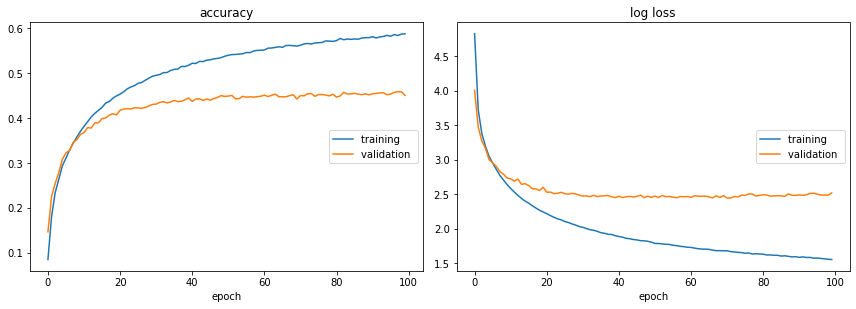

accuracy
	training         	 (min:    0.081, max:    0.588, cur:    0.588)
	validation       	 (min:    0.145, max:    0.459, cur:    0.450)
log loss
	training         	 (min:    1.551, max:    4.866, cur:    1.551)
	validation       	 (min:    2.443, max:    4.008, cur:    2.517)
76.95291209220886


In [0]:
model_save_name = 'SimpleNet_image_classifier_v4.pth'
path = F"/content/gdrive/My Drive/acse-miniproject/{model_save_name}" 
model = train_model(SimpleNet())

In [0]:
# model = SimpleNet()
# model_load_name = 'SimpleNet_image_classifier_v4.pth'
# path = F"/content/gdrive/My Drive/acse-miniproject/{model_load_name}" 
# model.load_state_dict(torch.load(path))
# model.to(device)

test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, num_workers=0)
prediction = evaluate(model, test_loader)[0]

In [0]:
## create test prediction csv
files_list = []
file_inds = np.zeros(len(test_data), dtype=int)
for i in range(len(test_data)):
    filename = os.path.split(test_data.samples[i][0])[1]
    filename = os.path.splitext(filename)[0]
    files_list.append(filename + '.jpeg')
    file_inds[i] = int(filename[5:])

inds = file_inds.argsort()

output = np.vstack((np.array(files_list)[inds], prediction[inds])).T
output = np.vstack((['Filename','Label'], output))
np.savetxt("/content/gdrive/My Drive/acse-miniproject/prediction.csv", output, delimiter=",", fmt=('%s','%s'))